### Part 3: Time series analysis


#### Load Data

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
import statsmodels.api as sm
os.environ["PYSPARK_PYTHON"] = "python3"

In [0]:
data_path = "dbfs:/projects/LA_crime/data/LA_crimedata.csv"

In [0]:
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.format("csv").option("header", "true").load(data_path)
from pyspark.sql.functions import *
# add new columns to convert Date to date format
# DataFrame.withColumn(): Returns a new DataFrame by adding a column or replacing the existing column that has the same name.
df_update = df.withColumn("Date Rptd", to_date(col("Date Rptd"), "MM/dd/yyyy hh:mm:ss a"))
df_update = df_update.withColumn('DATE OCC', to_date(df_update['DATE OCC'], 'MM/dd/yyyy hh:mm:ss a'))

df_update = df_update.withColumn('TIME OCC', to_timestamp(df_update['TIME OCC'], 'HHmm'))
df_update = df_update.withColumn('hour_OCC', hour(col('TIME OCC')))
df_update = df_update.withColumn('minute_OCC', minute(col('TIME OCC')))
df_update = df_update.withColumn('second_OCC', second(col('TIME OCC')))

df_update.createOrReplaceTempView("LA_crime")

In [0]:
%sql
select * from LA_crime limit 5

DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,hour_OCC,minute_OCC,second_OCC
001307355,2010-02-20,2010-02-20,1970-01-01T13:50:00.000+0000,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501,SINGLE FAMILY DWELLING,null,null,AA,Adult Arrest,900,null,null,null,300 E GAGE AV,null,33.9825,-118.2695,13,50,0
011401303,2010-09-13,2010-09-12,1970-01-01T00:45:00.000+0000,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",0329,0,M,W,101,STREET,null,null,IC,Invest Cont,740,null,null,null,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,0,45,0
070309629,2010-08-09,2010-08-09,1970-01-01T15:15:00.000+0000,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103,ALLEY,null,null,IC,Invest Cont,946,null,null,null,1300 E 21ST ST,null,34.0224,-118.2524,15,15,0
090631215,2010-01-05,2010-01-05,1970-01-01T01:50:00.000+0000,06,Hollywood,0646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101,STREET,102,HAND GUN,IC,Invest Cont,900,998,null,null,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,1,50,0
100100501,2010-01-03,2010-01-02,1970-01-01T21:00:00.000+0000,01,Central,0176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103,ALLEY,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122,null,null,null,8TH ST,SAN PEDRO ST,34.0387,-118.2488,21,0,0


#### Model building

In [0]:
ts = spark.sql(
"select \
  date(`DATE OCC`) as date, count(*) as number_of_crime \
from LA_crime \
group by 1 \
order by 1")

display(ts)

date,number_of_crime
2010-01-01,2337
2010-01-02,535
2010-01-03,539
2010-01-04,558
2010-01-05,548
2010-01-06,532
2010-01-07,550
2010-01-08,605
2010-01-09,631
2010-01-10,618


Databricks visualization. Run in Databricks to view.

In [0]:
ts.printSchema()

root
 |-- date: date (nullable = true)
 |-- number_of_crime: long (nullable = false)



In [0]:
ts.show(n=3)

+----------+---------------+
|      date|number_of_crime|
+----------+---------------+
|2010-01-01|           2337|
|2010-01-02|            535|
|2010-01-03|            539|
+----------+---------------+
only showing top 3 rows



In [0]:
ts.filter("date is null or number_of_crime is null").show()

+----+---------------+
|date|number_of_crime|
+----+---------------+
+----+---------------+



In [0]:
import itertools
p = d = q = range(0,2)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdq

Out[11]: [(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [0]:
#Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,2)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
y = ts.toPandas()
y.set_index('date', inplace=True)
# set index as DataTimeIndex
y.index = pd.to_datetime(y.index)
# The 'MS' string groups the data into buckets by start of the month
y = y['number_of_crime'].resample('MS').mean()
y.head()

Out[13]: date
2010-01-01    629.193548
2010-02-01    572.250000
2010-03-01    584.870968
2010-04-01    592.533333
2010-05-01    571.677419
Freq: MS, Name: number_of_crime, dtype: float64

In [0]:
optimal = {'param':None, 'param_seasonal':None, 'aic':None}
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

      results = mod.fit()
      if (not optimal['aic']) or results.aic < optimal['aic']:
        optimal['param'] = param
        optimal['param_seasonal'] = param_seasonal
        optimal['aic'] = results.aic
        print('optimal updated')
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue
print('optimal paramaters:', optimal)

optimal updated
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2026.7031488197692
optimal updated
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1727.2487129069723
optimal updated
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1489.2109814981854
optimal updated
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1328.7537928693384
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1488.47904428201
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1455.1144748612062
optimal updated
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1328.7528841248857
optimal updated
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1319.129046893882
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1846.5011741430487
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1570.7024631884074
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1371.2854646532453
optimal updated
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1239.114314234408
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1382.3262291262736
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1356.8285087713812
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1257.9894292416777
optimal updated
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC

In [0]:
optimal

Out[20]: {'param': (1, 1, 1),
 'param_seasonal': (0, 1, 1, 12),
 'aic': 1012.2577650034242}

In [0]:

mod = sm.tsa.statespace.SARIMAX(y,
                                order=optimal['param'],
                                seasonal_order=optimal['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8559      0.188      4.554      0.000       0.488       1.224
ma.L1         -0.7139      0.266     -2.689      0.007      -1.234      -0.194
ma.S.L12      -1.0000      0.053    -18.924      0.000      -1.104      -0.896
sigma2       667.3772   7.92e-05   8.43e+06      0.000     667.377     667.377


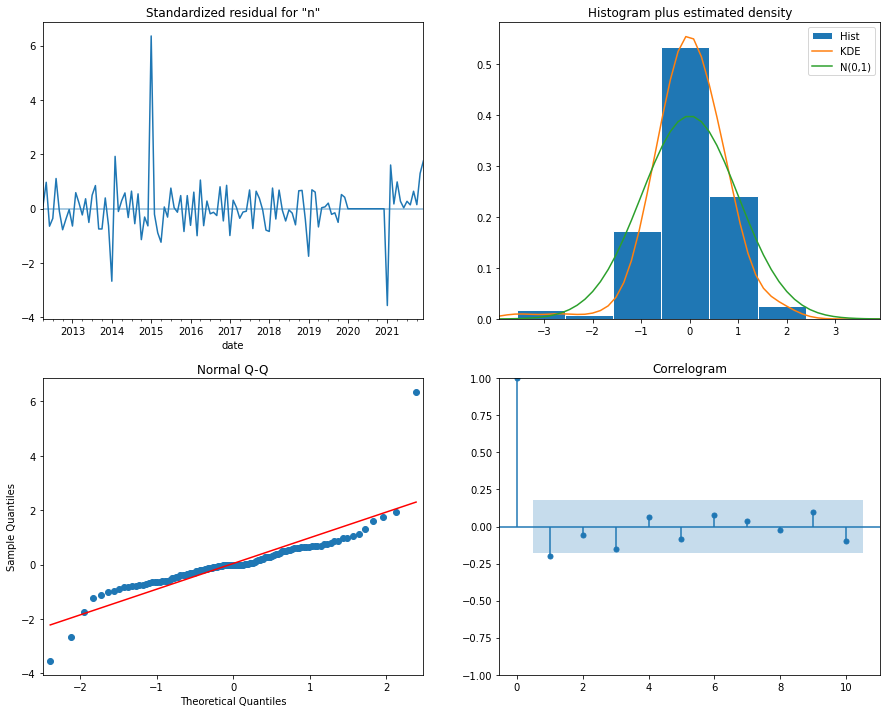

In [0]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

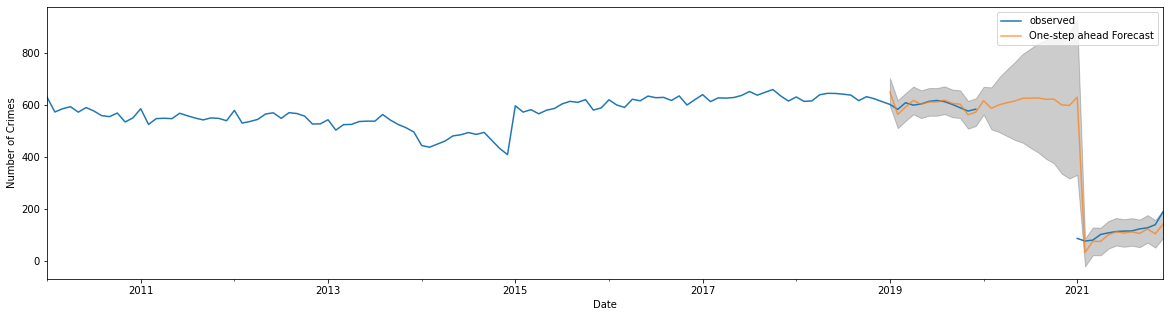

In [0]:

pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='observed', figsize=(20,5))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
plt.legend()

plt.show()

In [0]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is',mse)

The Mean Squared Error of our forecasts is 12784.604206097249


In [0]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

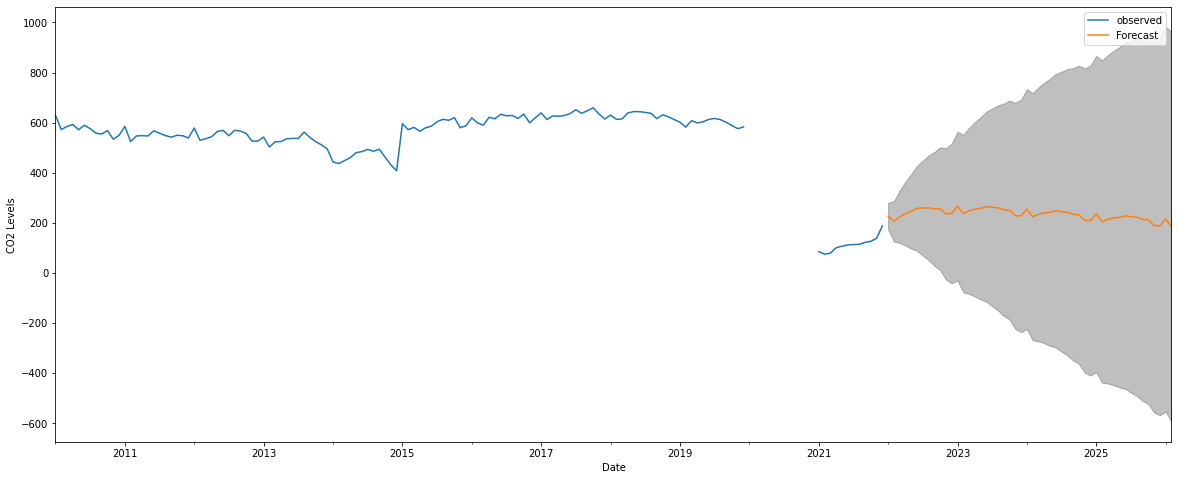

In [0]:
ax = y.plot(label='observed', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()